In [50]:
from FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset

dataset_train = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[2, 3, 4, 5],
        cutoff_dist=0.3,  # example cutoff distance
        use_static_features=False, # probaly not needed for now  
        load_energy=True,
        include_z=True
    )

dataset_val = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[6],
        cutoff_dist=0.3,  # example cutoff distance
        use_static_features=False, # probaly not needed for now  
        load_energy=True,
        include_z=True
    )

dataset_test = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[7],
        cutoff_dist=0.3,  # example cutoff distance
        use_static_features=False, # probaly not needed for now  
        load_energy=True,
        include_z=True
    )

Loading systems: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


In [51]:
dataset_train[5]

Data(x=[800, 5], edge_index=[2, 9168], edge_attr=[9168, 4], y=[800, 3], pos=[800, 3], energy=[1], z=[800], system_id=2, timestep=500)

In [52]:
from torch.utils.data import Subset
import torch

def indices_with_energy(ds):
    idxs = []
    for i in range(len(ds)):
        data = ds[i]
        if hasattr(data, "energy") and torch.is_tensor(data.energy):
            idxs.append(i)
        else:
            print(f"Dropping graph {i} from dataset (missing or invalid energy)")
    return idxs

train_idx = indices_with_energy(dataset_train)
val_idx   = indices_with_energy(dataset_val)
test_idx  = indices_with_energy(dataset_test)

dataset_train = Subset(dataset_train, train_idx)
dataset_val = Subset(dataset_val,   val_idx)
dataset_test = Subset(dataset_test,  test_idx)

Dropping graph 500 from dataset (missing or invalid energy)
Dropping graph 1001 from dataset (missing or invalid energy)
Dropping graph 1502 from dataset (missing or invalid energy)
Dropping graph 2003 from dataset (missing or invalid energy)
Dropping graph 500 from dataset (missing or invalid energy)
Dropping graph 500 from dataset (missing or invalid energy)


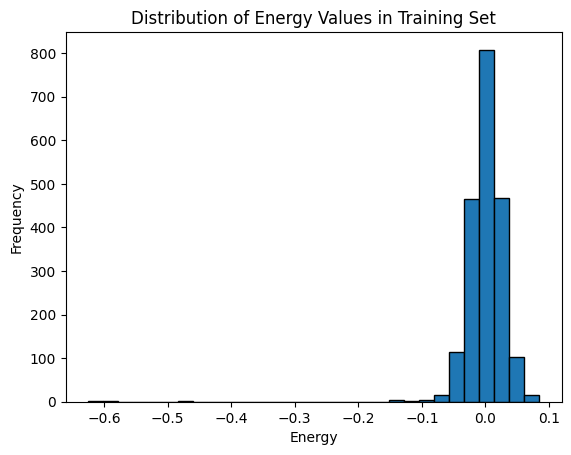

In [12]:
# Distribution of energy values in the training set as a histogram
import matplotlib.pyplot as plt
import numpy as np
energies = [data.energy.item() for data in graphs_train if hasattr(data, "energy") and data.energy is not None]
plt.hist(energies, bins=30, edgecolor='black')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Energy Values in Training Set')
plt.show()

In [9]:
from collections import defaultdict
import torch

sys_to_E_rel = defaultdict(list)

for data in d_train:  # or d_val/d_test
    sid = int(data.system_id) if not torch.is_tensor(data.system_id) else int(data.system_id.item())
    sys_to_E_rel[sid].append(data.energy.view(-1))

for sid, elist in sys_to_E_rel.items():
    E = torch.cat(elist, dim=0)
    print(f"System {sid}: mean(E_rel) = {E.mean().item():.6f}, "
          f"min = {E.min().item():.6f}, max = {E.max().item():.6f}")


System 2: mean(E_rel) = -10.498591, min = -11.106985, max = -10.417587
System 3: mean(E_rel) = -11.588668, min = -12.177138, max = -11.504221
System 4: mean(E_rel) = -9.437679, min = -9.909980, max = -9.362506
System 5: mean(E_rel) = -11.571424, min = -12.196442, max = -11.498107


In [53]:
from FeGdSpinGNN.utils import compute_normalization_stats, normalize_data

#Normailzation of targets from utils.py
stats = compute_normalization_stats(dataset_train)
train_normalized = [normalize_data(data, stats) for data in dataset_train]
val_normalized = [normalize_data(data, stats) for data in dataset_val]
test_normalized = [normalize_data(data, stats) for data in dataset_test]

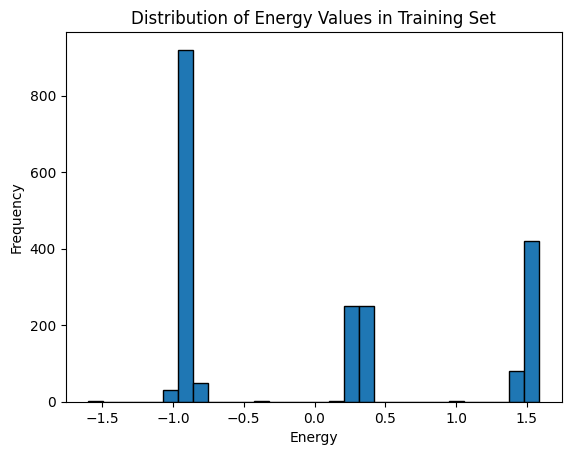

In [37]:
# Distribution of energy values in the training set as a histogram
import matplotlib.pyplot as plt
import numpy as np
energies = [data.energy.item() for data in train_normalized if hasattr(data, "energy") and data.energy is not None]
plt.hist(energies, bins=30, edgecolor='black')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Energy Values in Training Set')
plt.show()

In [54]:
print("energy_mean:", stats.get('energy_mean'))
print("energy_std:", stats.get('energy_std'))

energy_mean: tensor(-10.7741)
energy_std: tensor(0.8899)


In [55]:
#Create the dataloaders
from torch_geometric.loader import DataLoader

batch_size = 32

train_loader = DataLoader(train_normalized, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_normalized, batch_size=batch_size, shuffle=False)

In [56]:
print("energy_mean:", stats.get('energy_mean'))
print("energy_std:", stats.get('energy_std'))

batch = next(iter(train_loader))
print("batch.energy shape:", batch.energy.shape)
print("batch.energy mean:", batch.energy.mean().item())
print("batch.energy std:", batch.energy.std().item())

energy_mean: tensor(-10.7741)
energy_std: tensor(0.8899)
batch.energy shape: torch.Size([32])
batch.energy mean: 0.2231145054101944
batch.energy std: 1.0535075664520264


In [57]:
import torch
import torch.optim as optim
from FeGdSpinGNN.FeGd_initialmodel import SchNetFF
from FeGdSpinGNN.FeGd_energytrainer import EnergyTrainer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.nn.functional import mse_loss

model = SchNetFF(
    hidden_channels=32,
    num_interactions=10,
    cutoff=0.3,
    num_gaussians=25,
)


trainer = EnergyTrainer(
    model=model,
    device=device,
    loss_fn=mse_loss,
    lr=1e-3,   
)



In [58]:
history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    patience=5,
)



Starting training
Early stopping after 5 epochs without improvement


KeyboardInterrupt: 

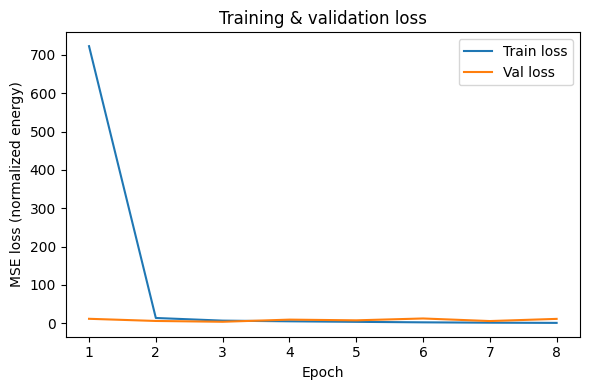

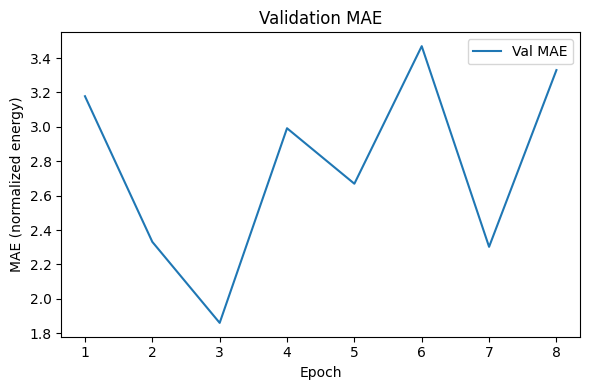

In [ ]:
import matplotlib.pyplot as plt

# Training curves
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, history['train_loss'][1:], label='Train loss')
plt.plot(epochs, history['val_loss'][1:],   label='Val loss')
plt.xlabel('Epoch') 
plt.ylabel('MSE loss (normalized energy)')
plt.title('Training & validation loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (normalized energy)')
plt.title('Validation MAE')
plt.legend()
plt.xlimits(1, len(history['val_mae']))
plt.tight_layout()
plt.show()


In [ ]:
import torch

model.eval()
all_pred_norm = []
all_true_norm = []

device = next(model.parameters()).device  # same device used in training

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)

        pred = model(
            x=batch.x,
            pos=batch.pos,
            edge_index=batch.edge_index,
            batch=batch.batch,
        )
        pred = pred.squeeze()              # shape [B]
        target = batch.energy.squeeze()    # normalized energy

        all_pred_norm.append(pred.cpu())
        all_true_norm.append(target.cpu())

all_pred_norm = torch.cat(all_pred_norm, dim=0)   # [N_test]
all_true_norm = torch.cat(all_true_norm, dim=0)   # [N_test]


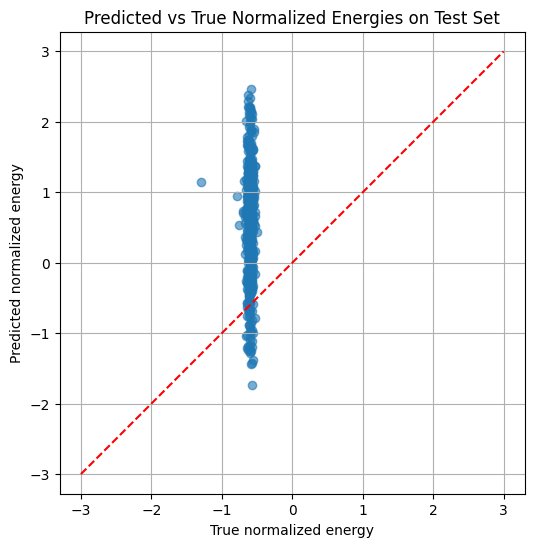

In [ ]:
# Scatter plot of predicted vs true energies
plt.figure(figsize=(6, 6))
plt.scatter(all_true_norm.numpy(), all_pred_norm.numpy(), alpha=0.6)
plt.plot([-3, 3], [-3, 3], color='red', linestyle
='--')  # y=x line
plt.xlabel('True normalized energy')
plt.ylabel('Predicted normalized energy')
plt.title('Predicted vs True Normalized Energies on Test Set')
plt.axis('equal')
plt.grid(True)
plt.show()

In [ ]:
energy_mean = stats['energy_mean']
energy_std  = stats['energy_std']

# Convert to same device / dtype if needed
energy_mean = energy_mean.to(all_pred_norm.dtype)
energy_std  = energy_std.to(all_pred_norm.dtype)

pred_raw  = all_pred_norm * energy_std + energy_mean   # predicted energy in physical units
true_raw  = all_true_norm * energy_std + energy_mean   # true energy in physical units


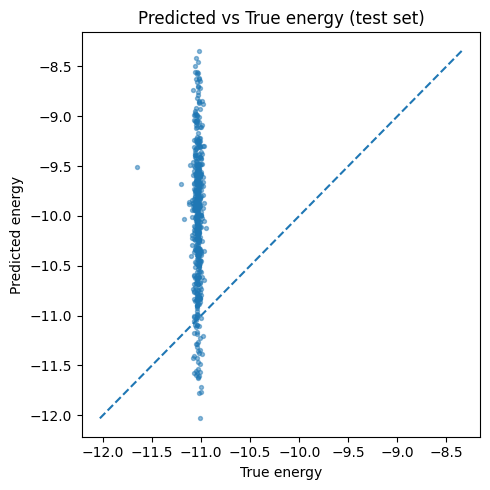

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

plt.scatter(true_raw.numpy(), pred_raw.numpy(), s=8, alpha=0.5)

# Reference y = x line
min_e = min(true_raw.min().item(), pred_raw.min().item())
max_e = max(true_raw.max().item(), pred_raw.max().item())
plt.plot([min_e, max_e], [min_e, max_e], linestyle='--')

plt.xlabel('True energy')
plt.ylabel('Predicted energy')
plt.title('Predicted vs True energy (test set)')
plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.nn import functional as F

def compute_B_from_energy_batch(model, batch, stats, device):
    """
    Given a batch with normalized x and y, compute predicted B-field from the
    energy model via autograd, and return B_pred_raw, B_true_raw.

    B_pred_raw: (N, 3), in same physical units as original B-field
    B_true_raw: (N, 3), same
    """
    model.eval()
    batch = batch.to(device)

    # --- normalization constants ---
    moment_std  = stats['moment_std'].to(device)      # (3,)
    energy_std  = stats['energy_std'].to(device)      # scalar
    target_mean = stats['target_mean'].to(device)     # (3,)
    target_std  = stats['target_std'].to(device)      # (3,)

    # --- build differentiable spin input ---
    # x = [type_onehot(2), spin_norm(3)]
    type_feats = batch.x[:, :2].detach()  # (N, 2), not trainable
    spin_norm  = batch.x[:, 2:5].detach().clone()  # (N, 3) normalized spin
    spin_norm.requires_grad_(True)  # we want dE/d(spin_norm)

    x_input = torch.cat([type_feats, spin_norm], dim=-1)  # (N, 5)

    # --- forward: normalized energy per graph ---
    energy_norm = model(
        x=x_input,
        pos=batch.pos,
        edge_index=batch.edge_index,
        batch=batch.batch,
    )  # shape [B] or [B,1]

    # We want gradient of sum of energies w.r.t spin_norm
    energy_norm_sum = energy_norm.sum()

    # Clear any existing grads on model (not strictly necessary if you don't care about param grads)
    model.zero_grad(set_to_none=True)

    # Compute gradient
    energy_norm_sum.backward()

    # grad_e_norm / grad_m_norm has shape (N, 3)
    grad_e_norm_wrt_m_norm = spin_norm.grad  # (N, 3)

    # --- convert to physical units with chain rule ---
    # E_raw = energy_std * e_norm + energy_mean
    # m_raw = moment_std * m_norm + moment_mean
    # => dE_raw/dm_raw = (energy_std / moment_std) * d(e_norm)/d(m_norm)

    factor = (energy_std / moment_std).view(1, 3)  # broadcast to (1,3)
    dEraw_dmraw = grad_e_norm_wrt_m_norm * factor  # (N,3)

    # Effective B is proportional to -dE/dm
    B_pred_raw = -dEraw_dmraw   # (N, 3)

    # --- recover true B in raw units from normalized y ---
    B_true_norm = batch.y       # (N, 3) normalized
    B_true_raw  = B_true_norm * target_std + target_mean

    return B_pred_raw.detach(), B_true_raw.detach()
